In [2]:
import torch
import numpy 
import cv2
import os
import torchvision
from tqdm import tqdm
from torch import nn, Tensor
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from typing import Optional

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2),
            nn.Conv2d((out_channel+in_channel)//2, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.layer(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_final=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channel, (out_channel+in_channel)//2, 3, 1, 1),
            nn.BatchNorm2d((out_channel+in_channel)//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d((in_channel+out_channel)//2, out_channel, 3, 1, 1)
        ]
        
        if not is_final:
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

In [4]:
class VAE(nn.Module):
    def __init__(self, input_channels=3, input_height=64, input_width=64, latent_dim=128):
        super().__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.enc1 = EncoderBlock(input_channels, 32)
        self.enc2 = EncoderBlock(32, 64)
        self.enc3 = EncoderBlock(64, 128)
        
        self.flattened_size = 128 * (input_height // 8) * (input_width // 8)
        
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_var = nn.Linear(self.flattened_size, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        self.dec1 = DecoderBlock(128, 64, is_final=False)
        self.dec2 = DecoderBlock(64, 32, is_final=False)
        self.dec3 = DecoderBlock(32, input_channels, is_final=True)
        self.final_activation = nn.Sigmoid()

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).detach()
        return mu + eps * std

    def encode(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, self.input_height // 8, self.input_width // 8)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        return self.final_activation(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

In [5]:
def vae_loss_function(recon_x, x, mu, log_var, beta=0.01):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + (beta * kld_loss)

In [6]:
class CelebFaceDataset(Dataset):
    def __init__(self, dataset:Optional[list], path='/home/chaitanya-kohli/Gen AI/Ass2/archive/img_align_celeba/img_align_celeba'):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.CenterCrop(178),
           T.Resize((64, 64)),
           T.RandomHorizontalFlip(p=0.5)
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

In [7]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = VAE().to(device)
# dataset = CelebFaceDataset()
# data = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# epochs = 1000
# loss_list = []

# fixed_images = next(iter(data)).to(device)[:8] 

# for epoch in range(epochs):
#     model.train()
#     tot_loss = 0
#     loop = tqdm(data, dynamic_ncols=True, desc=f"Epoch {epoch+1}/{epochs}")
    
#     for img in loop:
#         img = img.to(device)
#         opt.zero_grad()
#         recon_img, mu, log_var = model(img)
#         loss = vae_loss_function(recon_img, img, mu, log_var)
#         loss.backward()
#         opt.step()
#         tot_loss += loss.detach().cpu().item()
#         loop.set_postfix(loss=loss.item())

#     avg_loss = tot_loss / len(data)
#     loss_list.append(avg_loss)
#     print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

#     if (epoch + 1) % 10 == 0:
#         torch.save(model.state_dict(), f'vae_celeba_epoch_{epoch+1}.pth')
#         model.eval()
#         with torch.no_grad():
#             recon_fixed, _, _ = model(fixed_images)
#             comparison = torch.cat([fixed_images, recon_fixed], dim=0)
#             grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=False)
            
#             plt.figure(figsize=(12, 4))
#             plt.imshow(grid.permute(1, 2, 0))
#             plt.axis('off')
#             plt.title(f'Top: Original | Bottom: Reconstructed (Epoch {epoch+1})')
#             plt.show()
#             plt.close()

# plt.figure(figsize=(10, 5))
# plt.plot(loss_list, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('VAE Training Loss over Epochs')

# plt.legend()
# plt.grid(True)
# plt.show()

In [8]:
model = VAE().to('cuda')
weights = torch.load('vae_outputs/weights/vae_celeba_epoch_270.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [9]:
torch.cuda.empty_cache()

In [10]:
import pandas as pd
attr_csv = pd.read_csv("archive/list_attr_celeba.csv")
attr_csv.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [11]:
attr_csv = attr_csv.dropna()
smile_rows = attr_csv[attr_csv['Smiling'] == 1]
no_smile_rows = attr_csv[attr_csv['Smiling'] == -1]
smile_filenames = smile_rows['image_id'].tolist()
no_smile_filenames = no_smile_rows['image_id'].tolist()

In [12]:
smile_dataset = DataLoader(CelebFaceDataset(smile_filenames), batch_size=64, shuffle=True, num_workers=2, drop_last=True)
no_smile_dataset = DataLoader(CelebFaceDataset(no_smile_filenames), batch_size=64, shuffle=True, num_workers=2, drop_last=True)

In [13]:
@torch.no_grad()
def get_avg_vector(model, dataloader):
    vector = torch.zeros(64, 128).to('cuda')
    for img in tqdm(dataloader):
        mu,_ = model.encode(img.to('cuda'))
        vector +=mu
    return vector.mean(0)

smile_vec = get_avg_vector(model, smile_dataset)
no_smile_vec = get_avg_vector(model, no_smile_dataset)


100%|██████████| 1639/1639 [00:31<00:00, 51.72it/s]


In [14]:
to_make_smile_vec = smile_vec-no_smile_vec

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


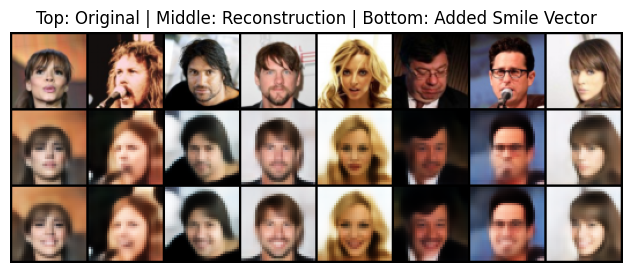

In [44]:
no_smile_sample = next(iter(no_smile_dataset))

with torch.no_grad():
    no_smile_mu, no_smile_var = model.encode(no_smile_sample[:8].to("cuda"))
    smile_mu = no_smile_mu + 0.001*to_make_smile_vec
    embed_no_smile = model.reparameterize(no_smile_mu, no_smile_var)
    embed_smile = model.reparameterize(smile_mu, no_smile_var)
    recon_no_smile = model.decode(embed_no_smile)
    recon_smile = model.decode(embed_smile)

comparison = torch.cat([
    no_smile_sample[:8].to('cuda'),
    recon_no_smile, 
    recon_smile
], dim=0)

# Make a grid (nrow=8 because we have 8 images per row)
grid = make_grid(comparison, nrow=8, padding=2, normalize=False)

# 3. Plot
plt.figure(figsize=(10, 3))
# Permute to (H, W, C) for matplotlib
plt.imshow(grid.cpu().detach().permute(1, 2, 0))
plt.axis('off')
plt.title("Top: Original | Middle: Reconstruction | Bottom: Added Smile Vector")
plt.show()